In [1]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd

In [2]:
ROUTES_PATH = 'http://tosamara.ru/api/classifiers/routesAndStopsCorrespondence.xml'

In [3]:
req = requests.get(ROUTES_PATH)
tree = ET.fromstring(req.text)
tree

<Element 'routes' at 0x000001704F637958>

In [4]:
routes = []
for child in tree:
    number = child[1].text
    direction = child[2].text
    type_id = int(child[3][0].text)
    performing = bool(child[4].text)
    geometry = child[-1].text.split(' ')
    routes.append({'number': number,
                  'direction': direction,
                  'type_id': type_id,
                  'performing' : performing,
                  'geometry' : geometry})

In [5]:
df_routes = pd.DataFrame.from_records(routes)
df_routes.head()

,direction,geometry,number,performing,type_id
0,Железнодорожный вокзал,"[53.384692,50.169369, 53.384749,50.169603, 53....",1,True,1
1,Красная Глинка,"[53.187111,50.121445, 53.18814,50.122168, 53.1...",1,True,1
2,Юнгородок,"[53.259224,50.216663, 53.259209,50.216672, 53....",21,True,1
3,Барбошина Поляна,"[53.213223,50.291229, 53.213392,50.291594, 53....",21,True,1
4,"кинотеатр ""Луч""","[53.213391,50.247921, 53.217799,50.24232, 53.2...",27,True,1


In [6]:
len(df_routes.number.unique())

169

In [7]:
def parse_geom(x):
    points = [(float(i.split(',')[0]),float(i.split(',')[1])) for i in x]
    edges = [(points[i-1],points[i]) for i in range(1, len(points))]
    return edges
df_routes['geo'] = df_routes['geometry'].apply(parse_geom)

In [8]:
global_edges = set()
for i in df_routes['geo'].values:
    global_edges = global_edges | set(i)

In [9]:
len(global_edges)

13313

In [10]:
df_routes.head()

,direction,geometry,number,performing,type_id,geo
0,Железнодорожный вокзал,"[53.384692,50.169369, 53.384749,50.169603, 53....",1,True,1,"[((53.384692, 50.169369), (53.384749, 50.16960..."
1,Красная Глинка,"[53.187111,50.121445, 53.18814,50.122168, 53.1...",1,True,1,"[((53.187111, 50.121445), (53.18814, 50.122168..."
2,Юнгородок,"[53.259224,50.216663, 53.259209,50.216672, 53....",21,True,1,"[((53.259224, 50.216663), (53.259209, 50.21667..."
3,Барбошина Поляна,"[53.213223,50.291229, 53.213392,50.291594, 53....",21,True,1,"[((53.213223, 50.291229), (53.213392, 50.29159..."
4,"кинотеатр ""Луч""","[53.213391,50.247921, 53.217799,50.24232, 53.2...",27,True,1,"[((53.213391, 50.247921), (53.217799, 50.24232..."


In [11]:
df_routes_perf = df_routes[df_routes.performing].drop(columns=['direction', 'performing', 'geometry'])
df_routes_perf.head()

,number,type_id,geo
0,1,1,"[((53.384692, 50.169369), (53.384749, 50.16960..."
1,1,1,"[((53.187111, 50.121445), (53.18814, 50.122168..."
2,21,1,"[((53.259224, 50.216663), (53.259209, 50.21667..."
3,21,1,"[((53.213223, 50.291229), (53.213392, 50.29159..."
4,27,1,"[((53.213391, 50.247921), (53.217799, 50.24232..."


In [12]:
req = requests.get('http://www.samaratrans.info/wiki/index.php/%D0%A1%D0%B0%D0%BC%D0%B0%D1%80%D0%B0_%D0%B0%D0%B2%D1%82%D0%BE%D0%B1%D1%83%D1%81_2')
html_text = req.text

In [13]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_text, 'html.parser')

In [14]:
collect_links = []
for j in soup.find_all('ul')[-6:]:
    for i in j.find_all('a'):
        try:
            if "маршруты" not in i['title'] and "расписания" not in i['title']:
                collect_links.append(i['href'])
        except KeyError:
            pass
len(collect_links)

199

In [15]:
def parse_add_inf(t):
    additional_information = t.find_all('td')
    add_inf = {}
    for i in range(0,14,2):
        add_inf[additional_information[i].text.strip()] = additional_information[i+1].text.strip()
    return add_inf


def parse_route_page(soup):
    try:
        tables = soup.find_all('table')
        route_name = tables[2].find_all('li')[0].text.split('\n\n')[0]
        return route_name, parse_add_inf(tables[7])
    except:
        return None, None

In [16]:
DOMAIN_LINK = 'http://www.samaratrans.info'

parsed_routes = {}

# for link in collect_links:
#     r = requests.get(DOMAIN_LINK+link)
#     s = BeautifulSoup(r.text, 'html.parser')
#     name, inf = parse_route_page(s)
#     parsed_routes[name] = inf
  

In [17]:
# with open('file.txt', 'w') as f:
#     f.write(str(parsed_routes))
with open('file.txt', 'r') as f:
    parsed_routes = eval(f.read())
# parsed_routes

In [18]:
type_dict = {int(i.split(' — ')[0]): i.split(' — ')[1] for i in '''1 — автобус, 2 — метрополитен, 3 — трамвай, 4 — троллейбус, 5 — электропоезд, 6 — речной транспорт'''.split(', ')}
type_dict

{1: 'автобус',
 2: 'метрополитен',
 3: 'трамвай',
 4: 'троллейбус',
 5: 'электропоезд',
 6: 'речной транспорт'}

In [19]:
routes_inf = []
exceptions = {}
for key, value in parsed_routes.items():
    try:
        key_splited = key.split(' ')
        number = key_splited[4]
        type_title = key_splited[1]
        schedule_days = { i.split(':')[0]: i.split(':')[1] 
                 for i in value['Режим работы'].split('По') if len(i.split(':')) > 1}
        intervals = value['Интервалы движения']
        vehicles = value['Подвижной состав']
        routes_inf.append([number, type_title, schedule_days, intervals, vehicles])
    except:
#         print(key, value)
        exceptions[key] = value

In [20]:
for key, value in exceptions.items():
    try:
        key_splited = key.split(' ')
        number = key_splited[4]
        type_title = key_splited[1]
        schedule_days = {value['Дни работы'] : value['Время работы'] }
        intervals = value['Интервалы движения']
        vehicles = value['Выпуск на линию']
        routes_inf.append([number, type_title, schedule_days, intervals, vehicles])
    except:
#         print(key, value)
        exceptions[key] = value

In [21]:
routes_inf.append(['7', 'Автобусный', {'Ежедневно': ' с 6 до 20 часов'}, 'По рабочим дням: 12-84 мин.По выходным дням: 68-164 мин.', 'ПАЗ-3203ПАЗ-3204ПАЗ-32054'])
routes_inf.append(['27', 'Автобусный', {'Ежедневно': ' с 6 до 20 часов'}, 'По рабочим дням: 12-44 мин.По субботам: 14-46 мин.По воскресеньям: 18-58 мин.', 'Hyundai County Kuzbas HDU2ПАЗ-3203ПАЗ-3204ПАЗ-32054'])
routes_inf.append(['59', 'Автобусный', {'Ежедневно': ' с 6 до 19 часов'}, '77 мин.', 'ПАЗ-3203'])
routes_inf.append(['59а', 'Автобусный', {'Ежедневно': ' с 6 до 19 часов'}, '77 мин.', 'ПАЗ-3203'])
routes_inf.append(['157', 'Автобусный', {'С 1 мая по 31 октября: по выходным и праздничным днямС 1 мая по 30 сентября: дополнительно по средам и пятницам(кроме дней массовых посещений кладбищ)': 'С 7 до 12 часов и с 15 до 20 часов'}, 'По рабочим дням: 30-35 мин.По выходным дням: 25-50 мин.', 'ЛиАЗ-5293.70МАЗ-206'])
routes_inf.append(['174', 'Автобусный', {'С 1 мая по 31 октября: по выходным и праздничным днямС 1 мая по 30 сентября: дополнительно по средам и пятницам(кроме дней массовых посещений кладбищ)': 'С 7 до 12 часов и с 16 до 19 часов'}, '45-50 мин.', 'МАЗ-206'])
routes_inf.append(['4', 'Трамвайный', {'Ежедневно': 'с 5 до 21 часа'}, '14 мин.', 'Tatra T3SU (Т-3) (одиночные вагоны)АКСМ-62103 (одиночные вагоны)'])
routes_inf.append(['4', 'Трамвайный', {' рабочим дням': ' с 6 до 23 часов', ' выходным дням': ' с 6 до 22 часов'}, 'По рабочим дням: 16 мин.По выходным дням: 14 мин.', 'Tatra T3SU (Т-3) (одиночные вагоны)АКСМ-62103 (одиночные вагоны)71-402 "СПЕКТР" (одиночные вагоны)'])

In [22]:
df_routes_inf = pd.DataFrame(routes_inf, columns=['number', 'type_title', 'schedule_days', 'intervals', 'vehicles'])
df_routes_inf.head()

,number,type_title,schedule_days,intervals,vehicles
0,1,Автобусный,{'Ежедневно': ' с 6 до 22 часов'},По рабочим дням: 8-20 мин.По выходным дням: 16...,ЛиАЗ-5293.70
1,3,Автобусный,{'Ежедневно': ' с 7 до 20 часов'},48-60 мин.,МАЗ-206
2,4,Автобусный,{'Ежедневно': ' с 6 до 21 часа'},7-10 мин.,Автобусы малого класса
3,5д,Автобусный,{'Ежедневно': ' с 5 до 22 часов'},По рабочим дням: 10-20 мин.По выходным дням: 1...,ЛиАЗ-5293.70
4,6,Автобусный,{'Ежедневно': ' с 6 до 21 часа'},По рабочим дням: 15-34 мин.По выходным дням: 1...,МАЗ-206


In [23]:
df_routes_inf.iloc[10].schedule_days = {'Ежедневно': 'С 7 до 20 часов'}
df_routes_inf.iloc[26].schedule_days = {'Ежедневно': 'С 6 до 20 часов'}

In [24]:
set([j for i in df_routes_inf.schedule_days.values for j in i.keys()])

{' выходным дням',
 ' рабочим дням',
 'В дни проведения мероприятий на стадионе "Самара Арена"Начало движения',
 'Выходные дни',
 'Ежедневно',
 'Пасха, Красная горка, Радоница, Троицкая родительская суббота, День Победы',
 'С 1 мая по 31 октября: по выходным и праздничным дням(кроме дней массовых посещений кладбищ)',
 'С 1 мая по 31 октября: по выходным и праздничным днямС 1 мая по 30 сентября: дополнительно по вторникам и четвергам(кроме дней массовых посещений кладбищ)',
 'С 1 мая по 31 октября: по выходным и праздничным днямС 1 мая по 30 сентября: дополнительно по средам и пятницам(кроме дней массовых посещений кладбищ)'}

Пасха, Красная горка, Радоница, Троицкая родительская суббота, День Победы 

Пасха - всегда воскресение
Красная горка- через неделю после Пасхи, тоже воскресение
Радоница - 9 дней после пасхи - вторник
Троицкая родительская суббота - суббота
День Победы - всегда выходной

In [25]:
def parse_time(text_time):
    words = text_time.strip().split(' ')
    if 'и ' in text_time:
        return list(range(int(words[1]), int(words[3]))) + list(range(int(words[7]), int(words[9])))
    return list(range(int(words[1]), int(words[3])))

def schedule_day(x):
    keys = x.schedule_days.keys()
    work_day, saturday, sunday, religion, arena, summer_weekend, summer_thu_tue, summer_wed_fri = [None for i in range(8)]
    if 'Ежедневно' in keys:
        work_day, saturday, sunday = [parse_time(x.schedule_days['Ежедневно']) for i in range(3)]
    if ' выходным дням' in keys:
        saturday, sunday = [parse_time(x.schedule_days[' выходным дням']) for i in range(2)]
    if 'Выходные дни' in keys:
        saturday, sunday = [parse_time(x.schedule_days['Выходные дни']) for i in range(2)]
    if ' рабочим дням' in keys:
        work_day = parse_time(x.schedule_days[' рабочим дням'])
    if 'В дни проведения мероприятий на стадионе "Самара Арена"Начало движения' in keys:
        arena = parse_time('с 15 до 23 часов')
    if 'Пасха, Красная горка, Радоница, Троицкая родительская суббота, День Победы' in keys:
        religion = parse_time(x.schedule_days['Пасха, Красная горка, Радоница, Троицкая родительская суббота, День Победы'])
    if 'С 1 мая по 31 октября: по выходным и праздничным дням(кроме дней массовых посещений кладбищ)' in keys:
        summer_weekend = parse_time(x.schedule_days['С 1 мая по 31 октября: по выходным и праздничным дням(кроме дней массовых посещений кладбищ)'])
    if 'С 1 мая по 31 октября: по выходным и праздничным днямС 1 мая по 30 сентября: дополнительно по вторникам и четвергам(кроме дней массовых посещений кладбищ)' in keys:
        summer_thu_tue = parse_time(x.schedule_days['С 1 мая по 31 октября: по выходным и праздничным днямС 1 мая по 30 сентября: дополнительно по вторникам и четвергам(кроме дней массовых посещений кладбищ)'])
    if 'С 1 мая по 31 октября: по выходным и праздничным днямС 1 мая по 30 сентября: дополнительно по средам и пятницам(кроме дней массовых посещений кладбищ)' in keys:
        summer_wed_fri = parse_time(x.schedule_days['С 1 мая по 31 октября: по выходным и праздничным днямС 1 мая по 30 сентября: дополнительно по средам и пятницам(кроме дней массовых посещений кладбищ)'])
    return pd.Series([work_day, saturday, sunday, religion, arena, summer_weekend, summer_thu_tue, summer_wed_fri])

df_routes_inf[['work_day', 'saturday', 'sunday', 'religion', 'arena', 'summer_weekend', 'summer_thu_tue', 'summer_wed_fri']] = df_routes_inf.apply(schedule_day, axis=1)

In [26]:
df_routes_inf.head()

,number,type_title,schedule_days,intervals,vehicles,work_day,saturday,sunday,religion,arena,summer_weekend,summer_thu_tue,summer_wed_fri
0,1,Автобусный,{'Ежедневно': ' с 6 до 22 часов'},По рабочим дням: 8-20 мин.По выходным дням: 16...,ЛиАЗ-5293.70,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None
1,3,Автобусный,{'Ежедневно': ' с 7 до 20 часов'},48-60 мин.,МАЗ-206,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]",None,None,None,None,None
2,4,Автобусный,{'Ежедневно': ' с 6 до 21 часа'},7-10 мин.,Автобусы малого класса,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None
3,5д,Автобусный,{'Ежедневно': ' с 5 до 22 часов'},По рабочим дням: 10-20 мин.По выходным дням: 1...,ЛиАЗ-5293.70,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",None,None,None,None,None
4,6,Автобусный,{'Ежедневно': ' с 6 до 21 часа'},По рабочим дням: 15-34 мин.По выходным дням: 1...,МАЗ-206,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None


In [27]:
df_routes_inf[df_routes_inf.religion.notna()]

,number,type_title,schedule_days,intervals,vehicles,work_day,saturday,sunday,religion,arena,summer_weekend,summer_thu_tue,summer_wed_fri
171,4к,Автобусный,"{'Пасха, Красная горка, Радоница, Троицкая род...",20-40 мин.,1-2 машины,None,None,None,"[7, 8, 9, 10, 11, 12, 13, 14]",None,None,None,None
172,27к,Автобусный,"{'Пасха, Красная горка, Радоница, Троицкая род...",10-20 мин.,4-6 машин,None,None,None,"[7, 8, 9, 10, 11, 12, 13, 14]",None,None,None,None
173,36д,Автобусный,"{'Пасха, Красная горка, Радоница, Троицкая род...",20-30 мин.,3-4 машины,None,None,None,"[7, 8, 9, 10, 11, 12, 13, 14]",None,None,None,None
174,36ю,Автобусный,"{'Пасха, Красная горка, Радоница, Троицкая род...",30 мин.,2 машины,None,None,None,"[8, 9, 10, 11, 12, 13]",None,None,None,None
175,63э,Автобусный,"{'Пасха, Красная горка, Радоница, Троицкая род...",5-10 мин.,До 25 машин,None,None,None,"[7, 8, 9, 10, 11, 12, 13, 14]",None,None,None,None
176,67к,Автобусный,"{'Пасха, Красная горка, Радоница, Троицкая род...",30-60 мин.,1-2 машины,None,None,None,"[7, 8, 9, 10, 11, 12, 13, 14]",None,None,None,None
177,77д,Автобусный,"{'Пасха, Красная горка, Радоница, Троицкая род...",15-20 мин.,4-5 машин,None,None,None,"[7, 8, 9, 10, 11, 12, 13, 14]",None,None,None,None
178,129э,Автобусный,"{'Пасха, Красная горка, Радоница, Троицкая род...",5-10 мин.,До 20 машин,None,None,None,"[7, 8, 9, 10, 11, 12, 13, 14]",None,None,None,None


In [28]:
df_routes_inf.intervals = df_routes_inf.intervals.apply(lambda x: '360 мин' if x == '-' else x)
df_routes_inf.intervals = df_routes_inf.intervals.apply(lambda x:  x.replace('до ', '') if 'до 80 мин.' in x else x)

In [29]:
def parse_mints(mints):
    if '-' in mints:
        mints = [int(i.strip()) for i in mints.split('-')]
        return sum(mints)/len(mints)
    return int(mints.strip())

def parse_intervals(x):
    parts = x.split('.')
    try:
        if ':' in x:
            return {i.split(':')[0] : parse_mints(i.split(':')[1].replace(' мин', '')) for i in parts if ':' in i}
        return {'always': parse_mints(parts[0].replace(' мин', ''))}
    except:
        print(x)
df_routes_inf['intervals_dict'] = df_routes_inf.intervals.apply(parse_intervals)
# t = 'По рабочим дням: 10-20 мин.По выходным дням: 20-30 мин.В вечернее время (после 20 часов): 30 мин.'
# parse_intervals(t)

In [30]:
# set([j for i in df_routes_inf.schedule_days.values for j in i.values()])
# df_routes_inf.intervals.unique()
# df_routes_inf.head()

In [31]:
def schedule_intervals(x):
    keys = x.intervals_dict.keys()
    work_day_int, sunday_int, saturday_int, int_18, int_19, int_20 = [None for i in range(6)]  
    if 'always' in keys:
        work_day_int, sunday_int, saturday_int, int_18, int_19, int_20 = [x.intervals_dict['always'] for i in range(6)]
    if 'По рабочим дням' in keys:
        work_day_int = x.intervals_dict['По рабочим дням'] 
    if 'По выходным дням' in keys:
        sunday_int, saturday_int = x.intervals_dict['По выходным дням'], x.intervals_dict['По выходным дням'] 
    if 'По субботам' in keys:
        saturday_int = x.intervals_dict['По субботам']
    if 'По воскресеньям' in keys:
        sunday_int = x.intervals_dict['По воскресеньям']
    if 'В вечернее время (после 18 часов)' in keys:
        int_18, int_19, int_20 = [x.intervals_dict['В вечернее время (после 18 часов)'] for i in range(3)]
    if 'В вечернее время (после 19 часов)' in keys:
        int_19, int_20 = [x.intervals_dict['В вечернее время (после 19 часов)'] for i in range(2)]
    if 'В вечернее время (после 20 часов)' in keys:
        int_20 = x.intervals_dict['В вечернее время (после 20 часов)']
    return pd.Series([work_day_int, sunday_int, saturday_int, int_18, int_19, int_20])

df_routes_inf[['work_day_int', 'sunday_int', 'saturday_int', 'int_18', 'int_19', 'int_20']] = df_routes_inf.apply(schedule_intervals, axis=1)

In [32]:
df_routes_inf.head()

,number,type_title,schedule_days,intervals,vehicles,work_day,saturday,sunday,religion,arena,summer_weekend,summer_thu_tue,summer_wed_fri,intervals_dict,work_day_int,sunday_int,saturday_int,int_18,int_19,int_20
0,1,Автобусный,{'Ежедневно': ' с 6 до 22 часов'},По рабочим дням: 8-20 мин.По выходным дням: 16...,ЛиАЗ-5293.70,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None,"{'По рабочим дням': 14.0, 'По выходным дням': ...",14.0,25.5,25.5,NaN,40.0,40.0
1,3,Автобусный,{'Ежедневно': ' с 7 до 20 часов'},48-60 мин.,МАЗ-206,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]",None,None,None,None,None,{'always': 54.0},54.0,54.0,54.0,54.0,54.0,54.0
2,4,Автобусный,{'Ежедневно': ' с 6 до 21 часа'},7-10 мин.,Автобусы малого класса,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None,{'always': 8.5},8.5,8.5,8.5,8.5,8.5,8.5
3,5д,Автобусный,{'Ежедневно': ' с 5 до 22 часов'},По рабочим дням: 10-20 мин.По выходным дням: 1...,ЛиАЗ-5293.70,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",None,None,None,None,None,"{'По рабочим дням': 15.0, 'По выходным дням': ...",15.0,19.5,19.5,25.5,25.5,25.5
4,6,Автобусный,{'Ежедневно': ' с 6 до 21 часа'},По рабочим дням: 15-34 мин.По выходным дням: 1...,МАЗ-206,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None,"{'По рабочим дням': 24.5, 'По выходным дням': ...",24.5,48.0,48.0,NaN,NaN,NaN


Если указан диапазон или разные комплектации единици траспорта, то взят минимум.

Если указана номинальная и максимальная вместимость, то взят максимум.

Если указаны и 1, и 2 вагона, то взято среднее.

Где машины не указаны:
- от 1 до 3 машин: вместимость Scania
- от 3 до 6 машин: МАЗ-206, как самый распространённый
- от 6 и выше: маршрутка

Если несколько разных ТС на маршруте - взято среднее

In [33]:
pass_count = pd.read_excel('samara_transport_passengers.xlsx', header=None)
pass_count_dict = {i[0]: i[1] for i in pass_count.to_dict('records')}

In [34]:
def pass_counting(x):
    lst = []
    for k, v in pass_count_dict.items():
        if k in x:
            lst.append(v)
    return sum(lst)/len(lst)
df_routes_inf['pass_count'] = df_routes_inf.vehicles.apply(pass_counting)

In [35]:
df_routes_capacity = df_routes_inf.copy()
df_routes_capacity = df_routes_capacity.drop(columns=['schedule_days','intervals','vehicles', 'intervals_dict'])
df_routes_capacity.head()

,number,type_title,work_day,saturday,sunday,religion,arena,summer_weekend,summer_thu_tue,summer_wed_fri,work_day_int,sunday_int,saturday_int,int_18,int_19,int_20,pass_count
0,1,Автобусный,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None,14.0,25.5,25.5,NaN,40.0,40.0,116.0
1,3,Автобусный,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]",None,None,None,None,None,54.0,54.0,54.0,54.0,54.0,54.0,72.0
2,4,Автобусный,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None,8.5,8.5,8.5,8.5,8.5,8.5,22.0
3,5д,Автобусный,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",None,None,None,None,None,15.0,19.5,19.5,25.5,25.5,25.5,116.0
4,6,Автобусный,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",None,None,None,None,None,24.5,48.0,48.0,NaN,NaN,NaN,72.0


In [36]:
def carrying(x, day, interval):
    lst = []
    capacity = x['pass_count']
    for i in range(5, 24, 1):
        try:
            if i in x[day]:
                if i == 18 and x['int_18'] > 0:
                    lst.append(capacity*60/x['int_18'])
                elif i == 19 and x['int_19'] > 0:
                    lst.append(capacity*60/x['int_19'])
                elif i == 20 and x['int_20'] > 0:
                    lst.append(capacity*60/x['int_20'])
                else:
                    lst.append(capacity*60/x[interval])
            else:
                lst.append(None)
        except TypeError:
            lst.append(None)
    return pd.Series(lst)

In [37]:
df_routes_capacity[['work_day_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'work_day', 'work_day_int'),axis=1)
df_routes_capacity[['saturday_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'saturday', 'saturday_int'),axis=1)
df_routes_capacity[['sunday_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'sunday', 'sunday_int'),axis=1)
df_routes_capacity[['religion_sun_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'religion', 'sunday_int'),axis=1)
df_routes_capacity[['religion_sat_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'religion', 'saturday_int'),axis=1)
df_routes_capacity[['religion_wd_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'religion', 'work_day_int'),axis=1)
df_routes_capacity[['arena_wd_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'arena', 'work_day_int'),axis=1)
df_routes_capacity[['arena_sun_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'arena', 'sunday_int'),axis=1)
df_routes_capacity[['arena_sat_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'arena', 'saturday_int'),axis=1)
df_routes_capacity[['summer_wed_fri_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'summer_wed_fri', 'work_day_int'),axis=1)
df_routes_capacity[['summer_thu_tue_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'summer_thu_tue', 'work_day_int'),axis=1)
df_routes_capacity[['summer_sun_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'summer_weekend', 'sunday_int'),axis=1)
df_routes_capacity[['summer_sat_{}'.format(i) for i in range(5, 24, 1)]] = df_routes_capacity.apply(
    lambda y: carrying(y, 'summer_weekend', 'saturday_int'),axis=1)

In [38]:
df_routes_capacity = df_routes_capacity.drop(columns=['work_day','saturday','sunday','religion','arena',
                                                      'summer_weekend','summer_thu_tue','summer_wed_fri',
                                                      'work_day_int','sunday_int','saturday_int',
                                                      'int_18','int_19','int_20','pass_count'])
df_routes_capacity.head()

,number,type_title,work_day_5,work_day_6,work_day_7,work_day_8,work_day_9,work_day_10,work_day_11,work_day_12,...,summer_sat_14,summer_sat_15,summer_sat_16,summer_sat_17,summer_sat_18,summer_sat_19,summer_sat_20,summer_sat_21,summer_sat_22,summer_sat_23
0,1,Автобусный,NaN,497.142857,497.142857,497.142857,497.142857,497.142857,497.142857,497.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,Автобусный,NaN,NaN,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,Автобусный,NaN,155.294118,155.294118,155.294118,155.294118,155.294118,155.294118,155.294118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5д,Автобусный,464.0,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,Автобусный,NaN,176.326531,176.326531,176.326531,176.326531,176.326531,176.326531,176.326531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_routes_capacity.to_csv('routes_capacity.csv', index=False)

In [40]:
df_routes_capacity.type_title.unique()

array(['Автобусный', 'Трамвайный', 'Троллейбусный'], dtype=object)

In [41]:
def remap_title(x):
    if x == 'Автобусный':
        return 1
    if x == 'Трамвайный':
        return 3
    if x == 'Троллейбусный':
        return 4
df_routes_capacity['type'] = df_routes_capacity.type_title.apply(remap_title)
df_routes_capacity = df_routes_capacity.drop(columns='type_title')

In [42]:
df_geo_capacity = df_routes_perf.join(df_routes_capacity.set_index(['number', 'type']), on=['number','type_id'])
df_geo_capacity.head()

,number,type_id,geo,work_day_5,work_day_6,work_day_7,work_day_8,work_day_9,work_day_10,work_day_11,...,summer_sat_14,summer_sat_15,summer_sat_16,summer_sat_17,summer_sat_18,summer_sat_19,summer_sat_20,summer_sat_21,summer_sat_22,summer_sat_23
0,1,1,"[((53.384692, 50.169369), (53.384749, 50.16960...",NaN,497.142857,497.142857,497.142857,497.142857,497.142857,497.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,"[((53.187111, 50.121445), (53.18814, 50.122168...",NaN,497.142857,497.142857,497.142857,497.142857,497.142857,497.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,1,"[((53.259224, 50.216663), (53.259209, 50.21667...",NaN,296.842105,296.842105,296.842105,296.842105,296.842105,296.842105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,1,"[((53.213223, 50.291229), (53.213392, 50.29159...",NaN,296.842105,296.842105,296.842105,296.842105,296.842105,296.842105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27,1,"[((53.213391, 50.247921), (53.217799, 50.24232...",NaN,98.142857,98.142857,98.142857,98.142857,98.142857,98.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
len(global_edges)

13313

In [44]:
# def geo_dummies(x):
#     return pd.Series([1 if i in x.geo else 0 for i in global_edges])
# df_geo_capacity.apply(geo_dummies, axis=1)
col = list(df_geo_capacity.columns)
col.remove('number')
col.remove('type_id')
col.remove('geo')


def edge_capacity(x, edge):
    if edge in x.geo:
        return pd.Series(x[col].values)
    return pd.Series([0 for i in col])

# itera = 1
# edge_weights = {}
# for i in global_edges:
#     print(i, ' ',itera, '/', len(global_edges))
#     edge_weights[i] = df_geo_capacity.apply(lambda y: edge_capacity(y, i), axis=1).sum().to_list()
#     itera+= 1

In [75]:
# edge_weights_df = pd.DataFrame.from_dict(edge_weights)
edge_weights_df = pd.read_csv('edge_weights_df.csv', index_col=0, header=None, low_memory=False).reset_index().drop(columns=0)
edge_weights_df.head()

,1,2,3,4,5,6,7,8,9,10,...,13304,13305,13306,13307,13308,13309,13310,13311,13312,13313
0,"(53.17861, 50.145116)","(53.230659, 50.278336)","(53.223391, 50.287776)","(53.496866, 50.056607)","(53.142111, 50.132257)","(53.143922, 50.049926)","(53.222906, 50.288585)","(53.237857, 50.216627)","(53.246244, 50.309452)","(53.210476, 50.298915)",...,"(53.213354, 50.142225)","(53.219476, 50.262903)","(53.197493, 50.221397)","(53.203002, 50.141237)","(53.279572, 50.228974)","(53.185539, 50.2306)","(53.466788, 50.126972)","(53.246484, 50.236666)","(53.104518, 50.162654)","(53.216867, 50.221214)"
1,"(53.178574, 50.144932)","(53.232807, 50.275488)","(53.223816, 50.286864)","(53.497173, 50.056795)","(53.141629, 50.131581)","(53.143703, 50.049673)","(53.22301, 50.288436)","(53.238367, 50.215984)","(53.246615, 50.309495)","(53.21054, 50.29874)",...,"(53.213857, 50.143322)","(53.219401, 50.262846)","(53.196812, 50.220343)","(53.202991, 50.140595)","(53.278671, 50.228817)","(53.184992, 50.229857)","(53.468213, 50.125531)","(53.246556, 50.23685)","(53.103448, 50.162266)","(53.216907, 50.221401)"
2,0.0,0.0,1342.2222222222222,0.0,254.6845261895242,758.1967213114754,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2820.0,0.0,0.0,0.0,0.0,66.0,0.0
3,0.0,56.5625,2862.222222222222,0.0,254.6845261895242,758.1967213114754,1626.6666666666667,1279.5,349.57142857142856,47.5,...,651.4679515912147,2117.1428571428573,1003.3333333333334,4297.942857142857,714.8621347644603,148.9655172413793,149.8108527131783,0.0,236.5,178.125
4,80.0,56.5625,2862.222222222222,0.0,254.6845261895242,758.1967213114754,1626.6666666666667,1279.5,349.57142857142856,47.5,...,651.4679515912147,2117.1428571428573,1003.3333333333334,4297.942857142857,714.8621347644603,148.9655172413793,149.8108527131783,0.0,243.83333333333331,178.125


In [76]:
len(edge_weights_df.columns)

13313

In [77]:
# edge_weights_df.to_csv('edge_weights_df.csv')

In [78]:
edge_w_df = edge_weights_df.transpose()
edge_w_df.columns = ['edge 1', 'edge 2'] + col
edge_w_df = edge_w_df.reset_index()
edge_w_df = edge_w_df.drop(columns = 'index')
edge_w_df.head()

,edge 1,edge 2,work_day_5,work_day_6,work_day_7,work_day_8,work_day_9,work_day_10,work_day_11,work_day_12,...,summer_sat_14,summer_sat_15,summer_sat_16,summer_sat_17,summer_sat_18,summer_sat_19,summer_sat_20,summer_sat_21,summer_sat_22,summer_sat_23
0,"(53.17861, 50.145116)","(53.178574, 50.144932)",0.0,0.0,80.0,80.0,80.0,80.0,80.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(53.230659, 50.278336)","(53.232807, 50.275488)",0.0,56.5625,56.5625,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"(53.223391, 50.287776)","(53.223816, 50.286864)",1342.2222222222222,2862.222222222222,2862.222222222222,2862.222222222222,1912.2222222222222,1912.2222222222222,1912.2222222222222,1912.2222222222222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"(53.496866, 50.056607)","(53.497173, 50.056795)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"(53.142111, 50.132257)","(53.141629, 50.131581)",254.6845261895242,254.6845261895242,254.6845261895242,254.6845261895242,254.6845261895242,254.6845261895242,254.6845261895242,254.6845261895242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
edge_w_df[col] = edge_w_df[col].astype(float)
len(edge_w_df)

13313

In [80]:
edge_w_df.describe()

,work_day_5,work_day_6,work_day_7,work_day_8,work_day_9,work_day_10,work_day_11,work_day_12,work_day_13,work_day_14,...,summer_sat_14,summer_sat_15,summer_sat_16,summer_sat_17,summer_sat_18,summer_sat_19,summer_sat_20,summer_sat_21,summer_sat_22,summer_sat_23
count,13313.000000,13313.000000,13313.000000,13313.000000,13313.000000,13313.000000,13313.000000,13313.000000,13313.000000,13313.000000,...,13313.0,13313.0,13313.0,13313.0,13313.000000,13313.0,13313.0,13313.0,13313.0,13313.0
mean,187.147372,762.841227,773.251970,771.393679,748.602098,748.109878,748.109878,747.508803,746.795215,747.566363,...,0.0,0.0,0.0,0.0,0.230639,0.0,0.0,0.0,0.0,0.0
std,436.964336,1177.555555,1185.167252,1181.666512,1147.024743,1146.695565,1146.695565,1146.653080,1146.942513,1147.765823,...,0.0,0.0,0.0,0.0,1.835268,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.000000,26.400000,26.400000,26.400000,26.400000,26.400000,26.400000,26.400000,26.400000,26.400000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.000000,169.169231,170.133333,170.133333,162.857143,162.857143,162.857143,162.857143,162.857143,162.857143,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
75%,66.000000,1177.576377,1181.458333,1179.383754,1113.594822,1113.594822,1113.594822,1109.285714,1109.285714,1109.285714,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
max,3301.822222,9344.338001,9556.891673,9556.891673,9556.891673,9556.891673,9556.891673,9556.891673,9556.891673,9556.891673,...,0.0,0.0,0.0,0.0,14.833333,0.0,0.0,0.0,0.0,0.0


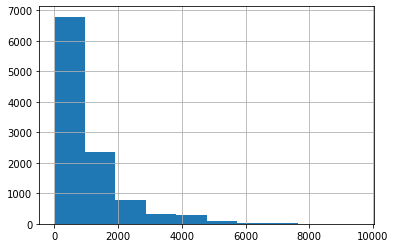

In [81]:
%matplotlib inline
edge_w_df.work_day_10[edge_w_df.work_day_10 > 0].hist()

In [52]:
def choose_color(x):
    if x > 4000:
        return '#009933'
    if x > 2000:
        return '#33cc33'
    if x > 1000:
        return '#66ff66'
    if x > 500:
        return '#99ff99'
    if x > 250:
        return '#ccffcc'
    return '#ffffff'
    

In [84]:
work_day_10_df = edge_w_df[edge_w_df.work_day_10 > 0][['edge 1', 'edge 2','work_day_10']].values
work_day_10_dict = {}
for i in work_day_10_df:
    k1 = i[0].replace('(', '').replace(')', '').split(', ')
    k2 = i[1].replace('(', '').replace(')', '').split(', ')
    k = ((float(k1[0]), float(k1[1])),(float(k2[0]), float(k2[1])))
    v = choose_color(i[2])
    work_day_10_dict[k] = v

In [86]:
import gpxpy
import gpxpy.gpx
import folium
import random

points = {j for i in list(global_edges) for j in i}

ave_lat = sum(p[0] for p in points)/len(points)
ave_lon = sum(p[1] for p in points)/len(points)

# Load map centred on average coordinates
my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=10)

#fadd lines
for k,v in work_day_10_dict.items():
    folium.PolyLine(k, color=v, weight=3, opacity=1).add_to(my_map)

# Save map
my_map.save("./work_day_10.html")
# my_map